In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
import pandas as pd
import numpy as np
from datetime import datetime
import time

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction='in')
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction='in') 

        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
#################################################################
def Vh2V3k(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    v3k = Vh-25.2*cosl*cosb-245.7*sinl*cosb+276.8*sinb

    return v3k

#################################################################

def Vcmb2Vmod(Vcmb, omegam=0.27):
    
    omegal=1.-omegam
    c=299800.
    z=Vcmb/c
    q0=0.5*(omegam-2.*omegal)
    fmod=1.+0.5*(1.-q0)*z-(1./6)*(1.-q0-3.*q0**2+1.)*z**2
    Vmod=c*z*fmod

    return Vmod
#################################################################

def Vh2Vls(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    vls = Vh-26.*cosl*cosb+317.*sinl*cosb-8.*sinb

    return vls
#################################################################

In [4]:
leda = pd.read_csv('Leda_bar.csv', delimiter='|')
leda = leda.set_index('PGC')

print(len(leda))

/home/ehsan/anaconda3/envs/py2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


397843


In [5]:
df = pd.read_csv('./all_cf4_sni1_sample.csv', delimiter='|')
df = df.rename(columns=lambda x: x.strip())
df = df.set_index('PGC')
df = df.drop(columns=['1PGC'])
print(len(df))
df.head()

1009


,SNIa,IDT17g,Vcmb,Vmod,DM_av,eDM,DM_pantheonplus,eDM_pantheonplus,DM_scolnic,eDM_scolnic,...,DM_twins,eDM_twins,DM_avelino,eDM_avelino,RA,DE,glon,glat,sgl,sgb
PGC,,,,,,,,,,,,,,,,,,,,,
250,2006sr,0,6914,7042,35.04,0.13,35.07,0.25,35.03,0.20,...,NaN,NaN,NaN,NaN,0.8958,23.2008,108.8693,-38.3606,316.3211,17.6720
282,2008hj,0,10921,11235,36.03,0.11,35.98,0.24,36.00,0.18,...,NaN,NaN,35.97,0.12,1.0064,-11.1742,85.7160,-70.5385,282.0792,8.9703
415,2003it,0,7165,7301,35.12,0.14,35.14,0.25,35.12,0.21,...,NaN,NaN,NaN,NaN,1.4517,27.4491,110.6597,-34.3329,320.8087,17.8681
465,2000dg,0,11092,11415,36.05,0.20,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.5588,8.8878,104.4513,-52.3545,301.9054,14.0485
515,2002hw,0,4796,4857,34.28,0.15,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.7062,8.6285,104.5597,-52.6445,301.6830,13.8439


In [6]:
catalogs = []
catalogs = ["sh0es"]
catalogs += ["pantheonplus"]
catalogs += ["scolnic"]
catalogs += ["csp1"]
catalogs += ["ganesh"]
catalogs += ["rest"]
catalogs += ["amanullah"]
catalogs += ["jha"]
catalogs += ["prieto"]
catalogs += ["hicken"]
catalogs += ["folatelli"]
catalogs += ["walker"]
catalogs += ["stahl"]
catalogs += ["twins"]
catalogs += ["avelino"]

In [7]:
for cat in catalogs:
    df["eDM_"+cat][df["DM_"+cat]==0] = np.nan
    df["DM_"+cat][df["DM_"+cat]==0] = np.nan
    df['PGC1_'+cat] = df.index
    df['PGC1_'+cat][df["DM_"+cat].isna()] = np.nan
    df['Vcmb_'+cat] = df["Vcmb"]
    df['Vcmb_'+cat][df["DM_"+cat].isna()] = np.nan
df.head()

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,SNIa,IDT17g,Vcmb,Vmod,DM_av,eDM,DM_pantheonplus,eDM_pantheonplus,DM_scolnic,eDM_scolnic,...,PGC1_folatelli,Vcmb_folatelli,PGC1_walker,Vcmb_walker,PGC1_stahl,Vcmb_stahl,PGC1_twins,Vcmb_twins,PGC1_avelino,Vcmb_avelino
PGC,,,,,,,,,,,,,,,,,,,,,
250,2006sr,0,6914,7042,35.04,0.13,35.07,0.25,35.03,0.20,...,NaN,NaN,NaN,NaN,250.0,6914.0,NaN,NaN,NaN,NaN
282,2008hj,0,10921,11235,36.03,0.11,35.98,0.24,36.00,0.18,...,NaN,NaN,NaN,NaN,282.0,10921.0,NaN,NaN,282.0,10921.0
415,2003it,0,7165,7301,35.12,0.14,35.14,0.25,35.12,0.21,...,NaN,NaN,NaN,NaN,415.0,7165.0,NaN,NaN,NaN,NaN
465,2000dg,0,11092,11415,36.05,0.20,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,465.0,11092.0,NaN,NaN,NaN,NaN
515,2002hw,0,4796,4857,34.28,0.15,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,515.0,4796.0,NaN,NaN,NaN,NaN


In [8]:
len(df)

1009

In [9]:
import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

In [10]:
df.columns

Index([u'SNIa', u'IDT17g', u'Vcmb', u'Vmod', u'DM_av', u'eDM',
       u'DM_pantheonplus', u'eDM_pantheonplus', u'DM_scolnic', u'eDM_scolnic',
       u'DM_csp1', u'eDM_csp1', u'DM_ganesh', u'eDM_ganesh', u'DM_rest',
       u'eDM_rest', u'DM_amanullah', u'eDM_amanullah', u'DM_jha', u'eDM_jha',
       u'DM_prieto', u'eDM_prieto', u'DM_hicken', u'eDM_hicken',
       u'DM_folatelli', u'eDM_folatelli', u'DM_walker', u'eDM_walker',
       u'DM_stahl', u'eDM_stahl', u'DM_sh0es', u'eDM_sh0es', u'DM_twins',
       u'eDM_twins', u'DM_avelino', u'eDM_avelino', u'RA', u'DE', u'glon',
       u'glat', u'sgl', u'sgb', u'PGC1_sh0es', u'Vcmb_sh0es',
       u'PGC1_pantheonplus', u'Vcmb_pantheonplus', u'PGC1_scolnic',
       u'Vcmb_scolnic', u'PGC1_csp1', u'Vcmb_csp1', u'PGC1_ganesh',
       u'Vcmb_ganesh', u'PGC1_rest', u'Vcmb_rest', u'PGC1_amanullah',
       u'Vcmb_amanullah', u'PGC1_jha', u'Vcmb_jha', u'PGC1_prieto',
       u'Vcmb_prieto', u'PGC1_hicken', u'Vcmb_hicken', u'PGC1_folatelli',
       u'Vcm

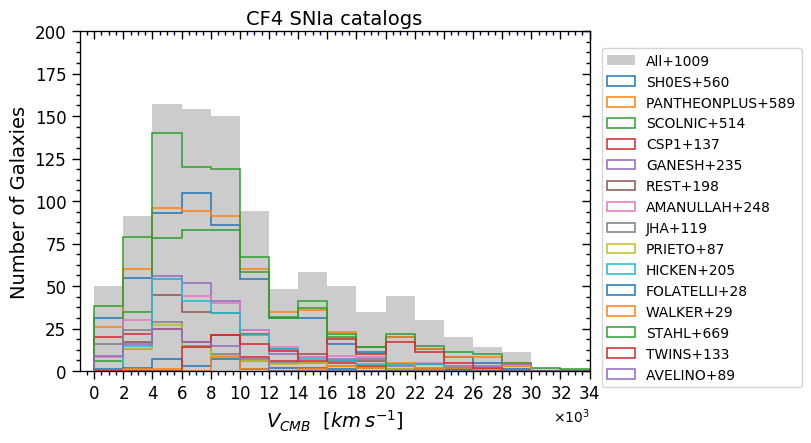

In [11]:
fig = plt.figure(figsize=(6, 4), dpi=100)
ax = fig.add_axes([0.13, 0.1, 0.85,  0.85])

bins=np.arange(0,36000,2000)

val = df.Vcmb.values
ax.hist(val, bins=bins, histtype='bar', label='All+'+str(len(val)), color='k', lw=1.7, alpha=0.2) 

for cat in catalogs:
    val = df[~df["DM_"+cat].isna()]["Vcmb"].values
    ax.hist(val, bins=bins, histtype='step', label=cat.upper()+'+'+str(len(val)), lw=1.1) 


###########################################################################
x_ax, y_ax = set_axes(ax, [-1000,34000], [0,200], fontsize=12, inout='out')


ax.set_xlabel(r"$V_{CMB}$"+"  "+r'$[km \/ s^{-1}]$', fontsize=14)
ax.set_ylabel("Number of Galaxies", fontsize=14)

ax.legend(bbox_to_anchor=(1.01, 0.97), loc='upper left', fontsize=10)

x_ax.set_xticks(np.arange(0, 36000, step=2000))
ax.set_xticks(np.arange(0, 36000, step=2000))


ax.set_title("CF4 SNIa catalogs", fontsize=14, pad=5)

ax.xaxis.set_major_formatter(OOMFormatter(3, "%d"))
ax.ticklabel_format(axis='x', style='sci')

In [12]:
import copy

df_all = copy.deepcopy(df)



In [13]:
import sys
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import  lines
from matplotlib import rc, rcParams
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.patches import Polygon, Ellipse
import numpy as np
from math import *
from time import time
import wl_to_rgb as col
import random
from astropy.io import ascii
from astropy.table import Table, Column 
import pyfits
import pylab as py
from astropy import coordinates as coord
from astropy import units as unit
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.patches as mpatches

from matplotlib import *

/home/ehsan/anaconda3/envs/py2/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [14]:
df = df_all # [df_all["Vgrp"]<16000]

vel = df.Vcmb.values

print np.min(vel), np.max(vel)


240 32575


In [15]:
len(df)

1009

In [16]:
df1 = pd.read_csv('de_jaeget_snii.csv', delimiter='|')
df1 = df1.rename(columns=lambda x: x.strip())

df1 = df1.set_index('PGC')


df1.head()

,1PGC,Nest,SNII,DM,eDM,Vhel,Vcmb,Vrc3,J2000,RA,De,Glon,Glat,SGL,SGB,Ty,Ag,Host,So
PGC,,,,,,,,,,,,,,,,,,,
2667,0,0,SN2008gr,34.66,0.33,6831,6549,6831,J004532.4-263355,11.3845,-26.5723,55.7606,-88.5691,270.2095,-4.9044,4.8,0.062,IC1579,Ned
5411,5271,201212,SN2007il,34.64,0.33,6454,6146,6437,J012709.5+144635,21.7906,14.7796,135.6967,-47.2082,312.8683,-3.5009,4.9,0.204,IC1704,Ned
5974,5974,212146,SN2013ej,29.80,0.97,657,359,658,J013641.8+154700,24.2007,15.7586,138.6172,-45.7054,314.5299,-5.3880,5.2,0.304,NGC628,Ned
6180,6161,201134,SN2008hg,34.75,0.35,5684,5449,5681,J014021.6-285446,25.0933,-28.9181,225.1639,-79.0619,270.4382,-17.2497,3.9,0.080,IC1720,Ned
6624,6415,200166,SN2001fa,34.28,0.35,5182,4893,5183,J014822.5+113118,27.0926,11.5262,144.4573,-48.9559,311.3392,-9.4130,5.3,0.335,NGC0673,Ned


In [17]:
df2 = pd.read_csv("All_CF4_4aitoff.csv")

df2.head()

,PGC,PGC1_VirFor,Vcmb_VirFor,PGC1_Tonry,Vcmb_Tonry,PGC1_Cantiello18,Vcmb_Cantiello18,PGC1_HydCen,Vcmb_HydCen,PGC1_HSTIR,Vcmb_HSTIR,PGC1,Vcmb,Vgrp,Ngrp,sgl,sgb
0,44298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44715.0,7609.879252,44715.0,7609.879252,7523.403989,2.0,89.96438,7.69567
1,44628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44715.0,7436.928726,44715.0,7436.928726,7523.403989,2.0,89.62618,8.27497
2,29822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29822.0,7170.644613,29822.0,7170.644613,7170.644613,1.0,65.26640,-18.41455
3,24848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24848.0,6750.878173,24848.0,6750.878173,6750.878173,1.0,188.81105,-39.97515
4,36487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36487.0,6562.361682,36487.0,6562.361682,6562.361682,1.0,92.05532,-10.56863


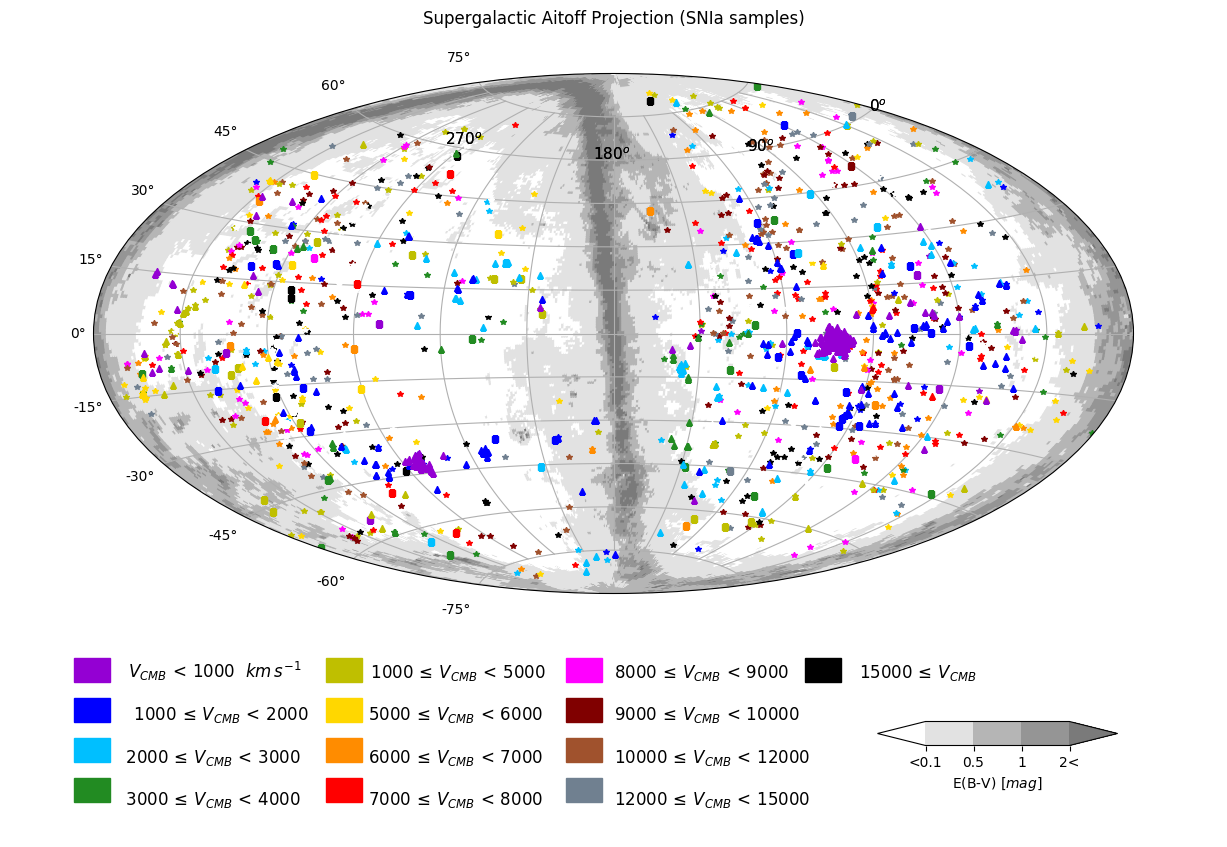

In [18]:
l0 = 180

deg = 0.8
a = pyfits.open('EBV.0.8.deg.fits')  # 0.8
d = a[1].data


SGL  = d['SGL']
SGB  = d['SGB']
EBV = d['EBV']

fig = plt.figure(figsize=(12, 8), dpi=100)
ax = fig.add_subplot(111, projection="aitoff")
plt.title("Supergalactic Aitoff Projection (SNIa samples)", y=1.08)
ax.grid(True)
ax.set_xticklabels([])
plt.subplots_adjust(top=0.95, bottom=0.3, right=0.95, left=0.05)

ax.annotate(r'$0^o$', (pi-0.1,pi/3.), size=11, color='black')
ax.annotate(r'$90^o$', (pi/2.-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$180^o$', (-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$270^o$', (-pi/2.-0.2,pi/3.), size=11, color='black')


ax.annotate(r'$0^o$', (pi-0.1,pi/3.), size=11, color='black')
ax.annotate(r'$90^o$', (pi/2.-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$180^o$', (-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$270^o$', (-pi/2.-0.2,pi/3.), size=11, color='black')  
################################################################ 
################################################################ 
def xymap_aitoff(x, y):
  
    while x > 360:
        x-=360
    while x < 0:
        x+=360

    x0 = (180.-x)*pi/180.
    y0 = y*pi/180.
  
    return x0, y0
################################################################ 

def esn_aitoff_patch(ax, x0, y0, d, color='blue'):

    vertices = []
    x, y = xymap_aitoff(x0,y0) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0,y0+d) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0+d,y0+d) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0+d,y0) 
    vertices.append([x,y]) 
    ax.add_patch(Polygon(vertices, closed=True, fill=True, color=color))


jet = cm = plt.get_cmap('Greys')
cNorm  = colors.Normalize(vmin=0, vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for i in range(len(SGB)):
    if EBV[i]>2.0: val = 3
    elif EBV[i]>1.0: val = 2.5
    elif EBV[i]>0.5: val= 2.0
    elif EBV[i]<=0.5 and EBV[i]>0.1: val= 1.0
    elif EBV[i]<0.1: val= 0
    else: val= 0
    colorVal = scalarMap.to_rgba(val)
    esn_aitoff_patch(ax, SGL[i], SGB[i], deg, color=colorVal)

    
    
# N = len(SGL)
# X = np.zeros(N)
# Y = np.zeros(N)
# for i in range(N):
#     X[i], Y[i] = xymap_aitoff(SGL[i], SGB[i])    
# ax.scatter(X, Y, marker='.', color='black')


sgl_gal = df.sgl.values
sgb_gal = df.sgb.values
N = len(sgl_gal)
X = np.zeros(N)
Y = np.zeros(N)
for i in range(N):
    X[i], Y[i] = xymap_aitoff(sgl_gal[i], sgb_gal[i])
    
############################################
    
# vel_col = np.zeros(N)   
# Velocity = df.Vcmb.values
# for i, v in enumerate(vel):
#     vel_col[i] = 0
#     if v<=0:
#         vel_col[i] = 0.1
#     elif v>=11000:
#         vel_col[i] = 1
#     else:
#         vel_col[i] = 0.1+0.9*v/11000.
    
# colours = pl.cm.nipy_spectral(vel_col)

############################################
col_pallet = ['darkviolet', 'blue', 'deepskyblue', 'forestgreen', 'y', 'gold', 'darkorange', 'red', 'magenta', 'maroon', 'sienna', 'slategrey', 'black']
vel_pallet = [-100000, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 12000, 15000, 20000]
def color_table(Velocity):
    colours = []
    for j, v in enumerate(Velocity):
        col = "white"
        for i in range(len(vel_pallet)-1):
            if vel_pallet[i] <= v and v < vel_pallet[i+1]:
                col = col_pallet[i]
                break
        colours.append(col)
    return colours

colours = color_table(df.Vcmb.values)
############################################

ax2 = plt.axes([0,0,1,1], facecolor=(1,1,1,0))
ax2.set_axis_off()
ax2.set_xticks([])
ax2.set_yticks([])
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.annotate(r"$\/\/ V_{CMB} \/ < \/ 1000 \/\/\/\/ km\/ s^{-1}  $", (0.1,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$ \/\/\/\/ 1000 \/ \leq \/ V_{CMB} \/ < \/ 2000$', (0.1,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 2000 \/ \leq \/ V_{CMB} \/ < \/ 3000$', (0.1,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 3000 \/ \leq \/ V_{CMB} \/ < \/ 4000$', (0.1,0.2-3*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 1000 \/ \leq \/ V_{CMB} \/ < \/ 5000$', (0.30,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$5000 \/ \leq \/ V_{CMB} \/ < \/ 6000$', (0.30,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$6000 \/ \leq \/ V_{CMB} \/ < \/ 7000$', (0.30,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$7000 \/ \leq \/ V_{CMB} \/ < \/ 8000$', (0.30,0.2-3*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$8000 \/ \leq \/ V_{CMB} \/ < \/ 9000$', (0.5,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$9000 \/ \leq \/ V_{CMB} \/ < \/ 10000$', (0.5,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$10000 \/ \leq \/ V_{CMB} \/ < \/ 12000$', (0.5,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$12000 \/ \leq \/ V_{CMB} \/ < \/ 15000$', (0.5,0.2-3*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$15000 \/ \leq \/ V_{CMB}$', (0.7,0.2), xycoords='figure fraction', size=12, color='black')

p = 0
for m in [0.1,0.31,0.51]:
    for n in [0.19,0.19-0.05,0.19-2*0.05,0.19-3*0.05]:
        ax2.add_patch(patches.Rectangle((m-0.05, n), 0.03, 0.03, color=col_pallet[p]))
        p+=1
ax2.add_patch(patches.Rectangle((0.71-0.05, 0.19), 0.03, 0.03, color=col_pallet[p]))
############################################
################################################################ 
jet = cm = plt.get_cmap('Greys')
cNorm  = colors.Normalize(vmin=0, vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
ax3 = fig.add_axes([0.720, 0.11, 0.2, 0.03])
cols = []
bounds = [0,1,2,3]
#cols.append(scalarMap.to_rgba(0))
cols.append(scalarMap.to_rgba(1.0))
cols.append(scalarMap.to_rgba(2.0))
cols.append(scalarMap.to_rgba(2.5))
#cols.append(scalarMap.to_rgba(3.0))



cm = colors.ListedColormap(cols)

cm.set_over(scalarMap.to_rgba(3.0))
cm.set_under(scalarMap.to_rgba(0))

cNorm  = colors.BoundaryNorm(bounds, cm.N)
cbar = colorbar.ColorbarBase(ax3, cmap=cm, norm=cNorm, orientation='horizontal',ticks=bounds, boundaries=[-1]+bounds+[4],extend='both',extendfrac='auto')
cbar.set_ticks(bounds)
cbar.ax.tick_params(labelsize=10) 
cbar.ax.set_xticklabels(['<0.1','0.5','1','2<'])  # horizontal colorbar

cbar.set_label('E(B-V) '+r'$[mag]$')
################################################################   



# ax.scatter(X, Y, color=colours, marker='.', s=3)

for i, c in enumerate(colours):
    ax.plot([X[i]], [Y[i]], color=c, marker='*', ms=4)
    

#################  de Jaeger SNII
colours = color_table(df1.Vcmb.values)
sgl_gal = df1.SGL.values
sgb_gal = df1.SGB.values
N = len(sgl_gal)
X = np.zeros(N)
Y = np.zeros(N)
for i in range(N):
    X[i], Y[i] = xymap_aitoff(sgl_gal[i], sgb_gal[i])
for i, c in enumerate(colours):
    ax.plot([X[i]], [Y[i]], color=c, marker='s', ms=5)
    
    
    
#################  all SBF
colours = color_table(df2.Vgrp.values)
sgl_gal = df2.sgl.values
sgb_gal = df2.sgb.values
N = len(sgl_gal)
X = np.zeros(N)
Y = np.zeros(N)
for i in range(N):
    X[i], Y[i] = xymap_aitoff(sgl_gal[i], sgb_gal[i])
for i, c in enumerate(colours):
    ax.plot([X[i]], [Y[i]], color=c, marker='^', ms=4)